In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Ross_Extent = pd.read_excel(filepath, sheet_name='Ross-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Ross_Extent)
fp.date_time(Ross_Extent)

Extent       Date
0    1040455.516 1979-01-01
1     239334.118 1979-02-01
2     557365.154 1979-03-01
3    2054855.924 1979-04-01
4    2973925.625 1979-05-01
..           ...        ...
533  3137598.938 2023-06-01
534  3201783.453 2023-07-01
535  2973294.266 2023-08-01
536  3354839.711 2023-09-01
537  3325613.245 2023-10-01

[538 rows x 2 columns]

In [5]:
scaler = MinMaxScaler()
Ross_Extent['Extent'] = scaler.fit_transform(Ross_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 2
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Ross_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((525, 12, 1), (525,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Ross_model_LT2/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 245ms/step - loss: 0.3778 - root_mean_squared_error: 0.6147 - val_loss: 0.2754 - val_root_mean_squared_error: 0.5248
Epoch 2/50
53/53 [==============================] - 12s 222ms/step - loss: 0.1919 - root_mean_squared_error: 0.4381 - val_loss: 0.0646 - val_root_mean_squared_error: 0.2543
Epoch 3/50
53/53 [==============================] - 11s 209ms/step - loss: 0.0489 - root_mean_squared_error: 0.2212 - val_loss: 0.0570 - val_root_mean_squared_error: 0.2388
Epoch 4/50
53/53 [==============================] - 12s 227ms/step - loss: 0.0430 - root_mean_squared_error: 0.2073 - val_loss: 0.0515 - val_root_mean_squared_error: 0.2268
Epoch 5/50
53/53 [==============================] - 11s 219ms/step - loss: 0.0407 - root_mean_squared_error: 0.2016 - val_loss: 0.0450 - val_root_mean_squared_error: 0.2122
Epoch 6/50
53/53 [==============================] - 12s 227ms/step - loss: 0.0363 - root_mean_squared_error: 0.1906 - val_loss: 0.0422 

53/53 [==============================] - 10s 199ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068
Epoch 29/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0105 - root_mean_squared_error: 0.1027 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1061
Epoch 30/50
53/53 [==============================] - 10s 196ms/step - loss: 0.0091 - root_mean_squared_error: 0.0952 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1050
Epoch 31/50
53/53 [==============================] - 10s 191ms/step - loss: 0.0088 - root_mean_squared_error: 0.0938 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1034
Epoch 32/50
53/53 [==============================] - 10s 185ms/step - loss: 0.0094 - root_mean_squared_error: 0.0968 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 33/50
53/53 [==============================] - 10s 195ms/step - loss: 0.0093 - root_mean_squared_error: 0.0962 - val_loss: 0.0099 - val_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

6.785609030723572 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

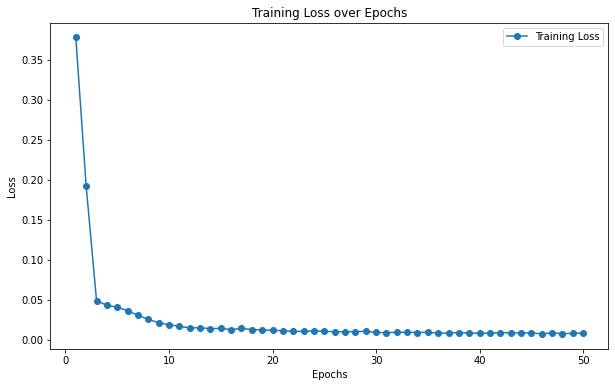

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

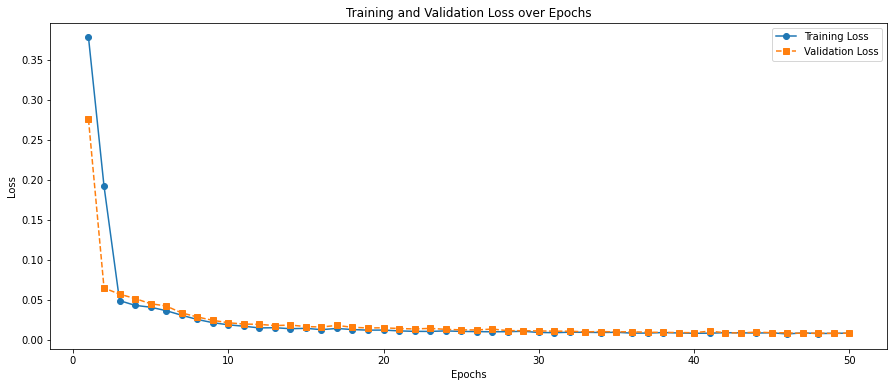

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Ross_model_LT2/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 27ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.08879813926386497
MAE : 0.0753026757465969


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

Train Predictions  Actual Extent
0         3223756.500    3168444.759
1         3616977.500    3656196.531
2         3759274.000    3794128.369
3         3800458.250    3885746.442
4         3760848.750    3909211.179
5         3412247.750    3499167.351
6         2427143.750    2715890.297
7          981982.375    1053272.694
8          689170.500     368862.123
9          983762.500     979418.298
10        1507573.875    2086269.569
11        2271255.750    2852731.016
12        2949294.750    3452823.613
13        3375363.500    3846843.974
14        3623988.250    4005222.451
15        3709191.000    4129684.505
16        3678982.000    4130311.577
17        3389337.750    3987590.376
18        2551798.750    2531664.630
19        1180986.125     864796.598
20         831799.250     366098.623
21        1147226.500    1324063.884
22        1773410.125    2094086.684
23        2563492.000    2706708.526
24        3186803.750    3380172.167
25        3564676.750    3975727.475
26        3751534.500    4016497.161
27        3838498.250    4134594.766
28        3859469.000    4278165.933
29        3643338.250    3893945.909
30        2743025.750    2389171.083
31        1049764.500     896425.932
32         825019.125     251374.224
33        1176770.250     455056.048
34        1818304.625    1780625.872
35        2538815.250    2914989.101
36        3169883.250    3561620.245
37        3588380.250    3991717.506
38        3786376.500    4559070.778
39        3856751.500    4596327.081
40        3881571.500    4565650.139
41        3677204.750    4061902.846
42        2641100.500    2336900.967
43        1013366.250     696917.659
44         790277.750     213657.789
45        1096013.250     765773.883
46        1713067.250    1951730.202
47        2632558.500    2610971.814
48        3397155.000    3137598.938
49        3747883.000    3201783.453
50        3883952.250    2973294.266
51        3949936.000    3354839.711
52        3951615.500    3325613.245

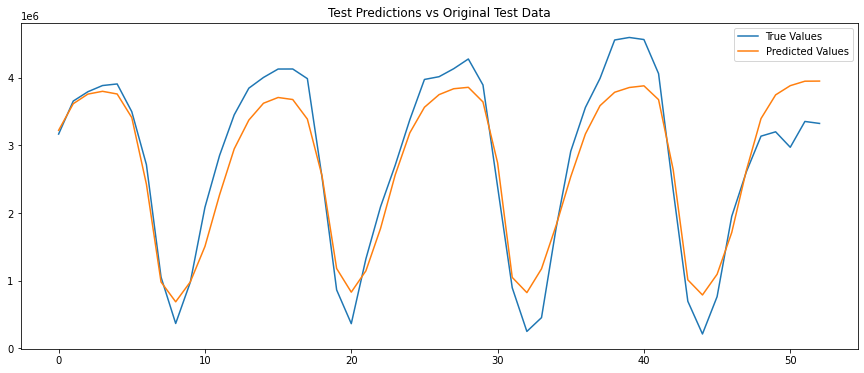

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 16ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

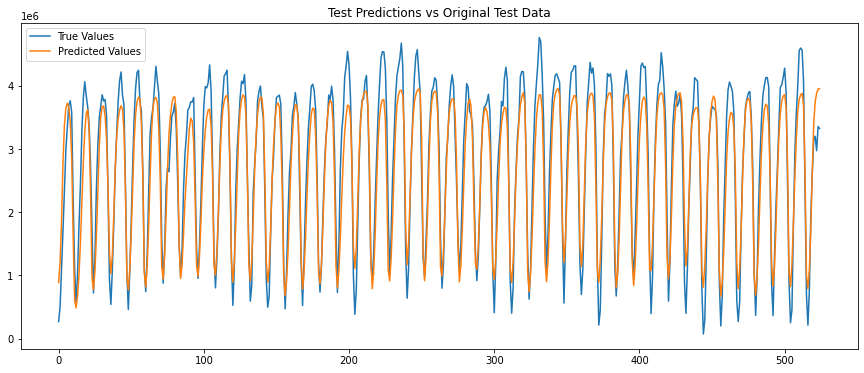

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()